In [1]:
import numpy as np
import time
import itertools
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set_palette('Set1', 10, desat=0.75)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def batched_hstack_csr(matrices, batch_size=-1):
    """
    Scipy sparse hstack operation works in linear time only on csc matrices or small csr matrices. 
    So in this function matrices hstacked by small batches, and then the batches are stacked vertically. Vertical
    stacking for csr matrices is a cheap operation.
    
    Input: 
        matrices: list of matrices to be hstacked. All must have the same number of rows. 
            Acceptable formats: csr matrix, pandas DataFrame or numpy array.
        batch_size: int, number of rows to hstack per batch. If not defined then batch_size is set equal to 
            the number of batches, i.e. square root of number of rows in matricies. Recommended batch size 1K - 10K.
    Output: scipy csr matrix consisting of matrices stacked horizontally   
    """
    if batch_size == -1 or batch_size == 'dynamic':
        batch_size = np.ceil(np.sqrt(matrices[0].shape[0]))
     
    if batch_size == 0 or batch_size >= matrices[0].shape[0]:
        return sparse.hstack(matrices, format='csr')
    
    batch_size = int(batch_size)
    batches = []
    for i in range(0, matrices[0].shape[0], batch_size):
        lower_bound = i
        upper_bound = min(i+batch_size, matrices[0].shape[0])
        batches.append(sparse.hstack([matrix[lower_bound:upper_bound] for matrix in matrices]
                                     , format='csr'))
    
    return sparse.vstack(batches, format='csr')

# Dummy data creation

Dense data is generated via np.random.uniform. 

In order to generate sparse data we'll generate *NROWS* random sentences where each word is an integer from range (0, *NCOLS_SPARSE*) converted into a string. Number of words in each sentence equals to *NCOLS_SPARSE* \* *SPARSE_DENSITY*. Resulted coprus is then transformed via CountVectorizer to sparse matrix.

In [3]:
%%time
# init parameters
NROWS = int(2e6)
NCOLS_DENSE = 200
NCOLS_SPARSE = int(1e5) # approximate 
SPARSE_DENSITY = 2e-4

# Dense data creation
data_dense = np.random.uniform(size=[NROWS, NCOLS_DENSE])

# Sparse data creation. 
words_in_sentence = int(NCOLS_SPARSE*SPARSE_DENSITY)
corpus = np.random.choice(size=[NROWS, words_in_sentence], a=NCOLS_SPARSE)
corpus = list((map(lambda x: ' '.join(x.astype(str)), corpus)))
print ('Example of 3 sentences for sparse matrix creation:')
for sentence in corpus[:3]:
    print (sentence)
print()

vectorizer = CountVectorizer().fit(corpus) 
data_sparse = vectorizer.transform(corpus)

print ('Dense  data shape:', data_dense.shape)
print ('Sparse data shape:', data_sparse.shape, '\n')

Example of 3 sentences for sparse matrix creation:
33826 78144 12578 15107 76381 7215 52797 81362 98275 62547 33130 66821 69716 36657 44267 76505 71821 33206 33926 50980
34291 19446 82806 56187 23389 16622 51862 3874 36980 88715 33179 61473 14348 52711 59903 41280 57817 65285 38657 67928
96492 38355 39335 77741 6273 24016 30458 28078 16818 34646 28965 58253 30316 89954 4516 57599 5868 32126 22065 33686

Dense  data shape: (2000000, 200)
Sparse data shape: (2000000, 99990) 

CPU times: user 2min 25s, sys: 4.89 s, total: 2min 30s
Wall time: 2min 32s


In [4]:
# check whether function returns the same result as default hstack
assert (sparse.hstack([data_sparse[:200], data_dense[:200]], format='csr') 
        == batched_hstack_csr([data_sparse[:200], data_dense[:200]])).toarray().all()

# Hstacking two sparse matrices

In [5]:
%%time
number_of_trials = 4 #  Number of trials for each matrix size. Is used to calculate 95% confedence intervals
nrows_list = np.array([1e4, 2.5e4, 5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 1.25e6, 1.5e6, 1.75e6, 2e6]).astype(int)

default_time_means = []
default_time_stds  = []

batched_time_means = []
batched_time_stds  = []

for nrows in nrows_list:
    print ('Started on {} row'.format(nrows)) 
    
    default_trials = []
    batched_trials = []
    
    for trial_num in range(number_of_trials):
        
        # Measuring scipy sparse hstack performance
        t_start = time.time()
        _ = sparse.hstack([data_sparse[:nrows], data_sparse[:nrows]], format='csr')
        default_trials.append(time.time() - t_start)
        
        # Measuring batched scipy sparse hstack performance
        t_start = time.time()
        _ = batched_hstack_csr([data_sparse[:nrows], data_sparse[:nrows]])
        batched_trials.append(time.time() - t_start)
        
    default_time_means.append(np.mean(default_trials))
    batched_time_means.append(np.mean(batched_trials))
    
    default_time_stds.append( 2*np.std(default_trials, ddof=1)/np.sqrt(number_of_trials) )
    batched_time_stds.append( 2*np.std(batched_trials, ddof=1)/np.sqrt(number_of_trials) )

Started on 10000 row
Started on 25000 row
Started on 50000 row
Started on 100000 row
Started on 250000 row
Started on 500000 row
Started on 750000 row
Started on 1000000 row
Started on 1250000 row
Started on 1500000 row
Started on 1750000 row
Started on 2000000 row
CPU times: user 14min 49s, sys: 2min 18s, total: 17min 8s
Wall time: 17min 28s


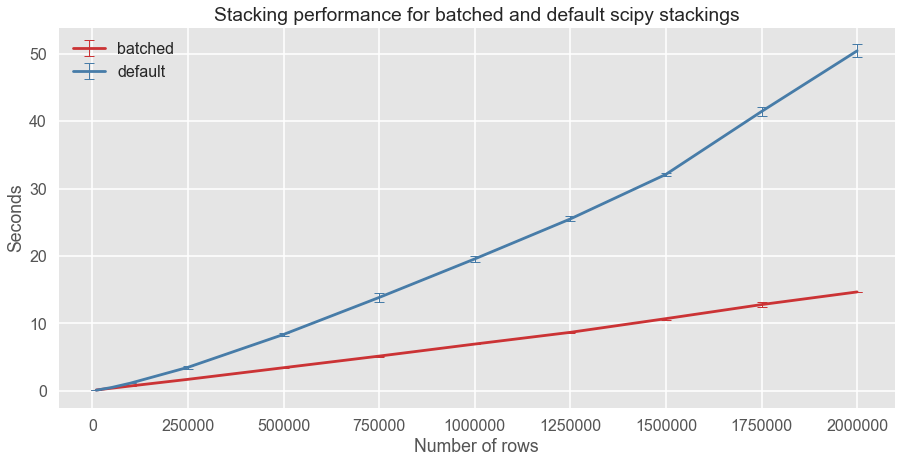

In [6]:
plt.figure(figsize=(15,7))

plt.errorbar(x=nrows_list, y=batched_time_means, label='batched',
             yerr=batched_time_stds, capthick=1, capsize=5, elinewidth=1)

plt.errorbar(x=nrows_list, y=default_time_means, label='default',
             yerr=default_time_stds, capthick=1, capsize=5, elinewidth=1)

plt.title('Stacking performance for batched and default scipy stackings')
plt.ylabel('Seconds')
plt.xlabel('Number of rows')
plt.legend()
plt.show()

# Hstacking dense and sparse matrices

In [7]:
%%time

number_of_trials = 4
nrows_list = np.array([1e4, 5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 1.25e6, 1.5e6]).astype(int)

default_time_means = []
default_time_stds = []

batched_time_means = []
batched_time_stds = []

for nrows in nrows_list:
    print ('Started on {} row'.format(nrows)) 
    
    default_trials = []
    batched_trials = []
    for trial_num in range(number_of_trials):

        t_start = time.time()
        _ = sparse.hstack([data_dense[:nrows], data_sparse[:nrows]], format='csr')
        default_trials.append(time.time() - t_start)
        
        t_start = time.time()
        _ = batched_hstack_csr([data_dense[:nrows], data_sparse[:nrows]])
        batched_trials.append(time.time() - t_start)
        
    default_time_means.append(np.mean(default_trials))
    batched_time_means.append(np.mean(batched_trials))
    
    default_time_stds.append( 2*np.std(default_trials, ddof=1)/np.sqrt(number_of_trials) )
    batched_time_stds.append( 2*np.std(batched_trials, ddof=1)/np.sqrt(number_of_trials) )

Started on 10000 row
Started on 50000 row
Started on 100000 row
Started on 250000 row
Started on 500000 row
Started on 750000 row
Started on 1000000 row
Started on 1250000 row
Started on 1500000 row
CPU times: user 37min 32s, sys: 32min 26s, total: 1h 9min 58s
Wall time: 1h 37min 23s


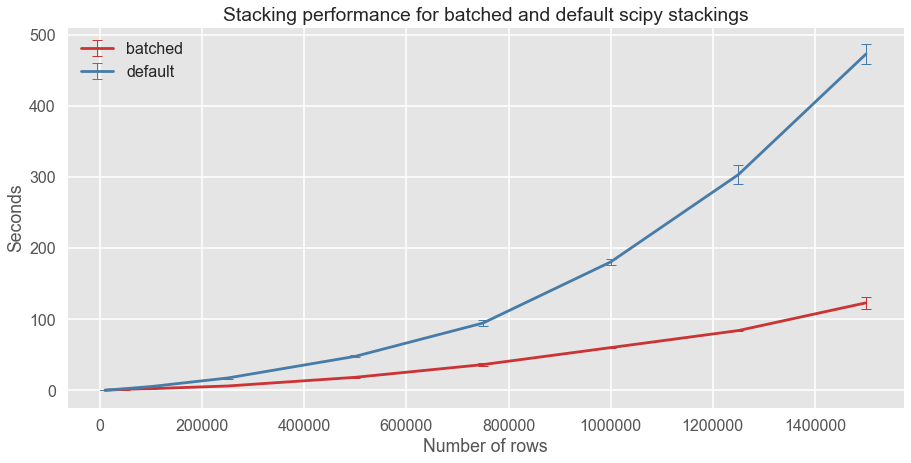

In [8]:
plt.figure(figsize=(15,7))

plt.errorbar(x=nrows_list, y=batched_time_means, label='batched',
             yerr=batched_time_stds, capthick=1, capsize=5, elinewidth=1)

plt.errorbar(x=nrows_list, y=default_time_means, label='default',
             yerr=default_time_stds, capthick=1, capsize=5, elinewidth=1)

plt.title('Stacking performance for batched and default scipy stackings')
plt.ylabel('Seconds')
plt.xlabel('Number of rows')

plt.legend()
plt.show()

# Batch size influence on performance, closer look on small datasets

In [9]:
%%time

number_of_trials = 5
nrows_list = np.array([1e4, 5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 1.25e6, 1.5e6]).astype(int)

batches_list = ['dynamic', 100, 1000, 10000, 100000]

batched_time_means = dict()
batched_time_stds = dict()

iter_num = 0
for nrows, batch_size in itertools.product(nrows_list, batches_list):
    if iter_num % len(batches_list)==0:
        print ('Started on {} row'.format(nrows)) 
    
    batched_time_means.setdefault(batch_size, [])
    batched_time_stds .setdefault(batch_size, [])        
    
    trials = []
    for trial_num in range(number_of_trials):
        
        t_start = time.time()
        _ = batched_hstack_csr([data_dense[:nrows], data_sparse[:nrows]], batch_size=batch_size)
        trials.append(time.time() - t_start)
    
    batched_time_means[batch_size].append(np.mean(trials))
    batched_time_stds [batch_size].append( 2*np.std(trials, ddof=1)/np.sqrt(number_of_trials) )
    
    iter_num+=1

Started on 10000 row
Started on 50000 row
Started on 100000 row
Started on 250000 row
Started on 500000 row
Started on 750000 row
Started on 1000000 row
Started on 1250000 row
Started on 1500000 row
CPU times: user 1h 12min 41s, sys: 29min 23s, total: 1h 42min 5s
Wall time: 2h 14min 24s


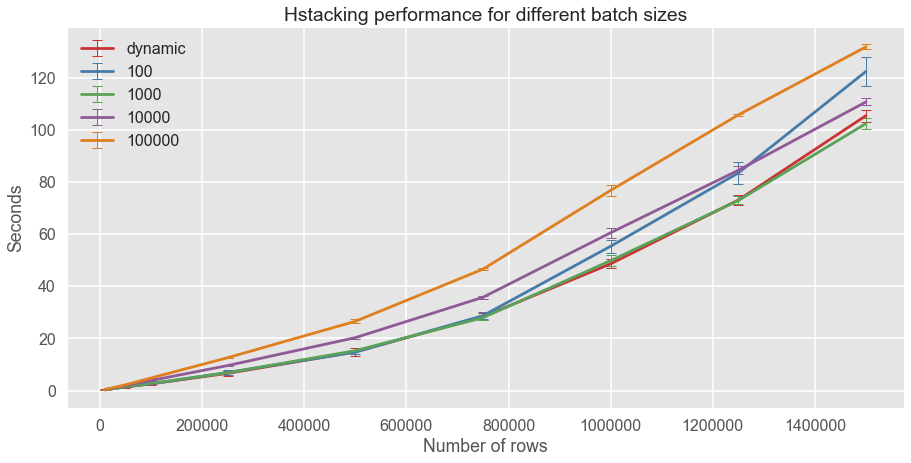

In [10]:
plt.figure(figsize=(15,7))

for batch_size in batches_list:
    
    plt.errorbar(x=nrows_list, y=batched_time_means[batch_size], label=batch_size,
                 yerr=batched_time_stds[batch_size], capthick=1, capsize=5, elinewidth=1)

plt.legend()
plt.title('Hstacking performance for different batch sizes')
plt.ylabel('Seconds')
plt.xlabel('Number of rows')
plt.show()

We can't really see anything on the graph above. Let's plot bar plots for every dataset size.

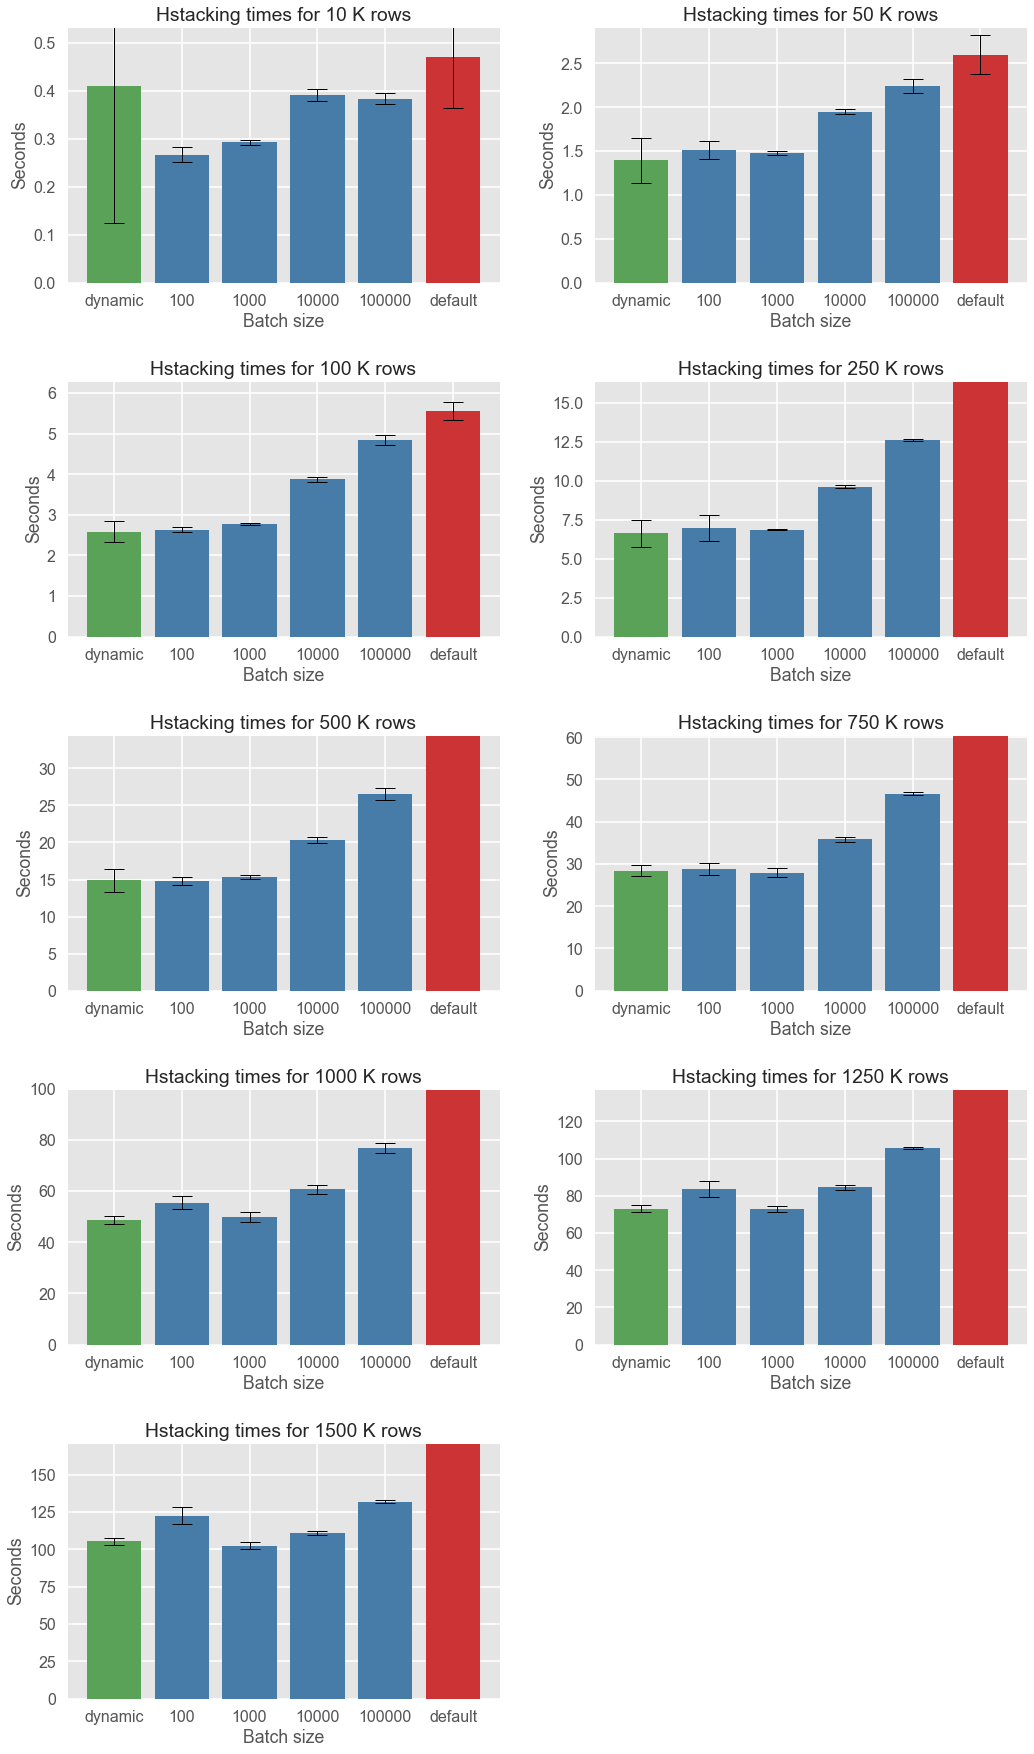

In [13]:
graph_nrows = np.ceil(nrows_list.shape[0]/2)
plt.figure(figsize=(15, 5*graph_nrows))

for nrows_index in range(nrows_list.shape[0]):
    bar_heights = [batched_time_means[batch_size][nrows_index] for batch_size in batches_list]
    bar_heights.append(default_time_means[nrows_index])
    
    bar_yerrors = [batched_time_stds[batch_size][nrows_index] for batch_size in batches_list] 
    bar_yerrors.append(default_time_stds[nrows_index])
    
    colors = [sns.color_palette()[2]] + [sns.color_palette()[1] for i in batches_list[:-1]] + [sns.color_palette()[0]]
    
    plt.subplot(graph_nrows, 2, nrows_index+1)
    plt.bar(left = range(len(bar_heights))
           ,height = bar_heights
           ,yerr = bar_yerrors
           ,capsize = 10
           ,error_kw = {'elinewidth':1, 'capsize':10, 'capthick':1}
           ,color = colors
           )
    plt.title('Hstacking times for {} K rows'.format(int(nrows_list[nrows_index]/1000)))
    plt.ylabel('Seconds')
    plt.xlabel('Batch size')
    plt.ylim(0, np.max(bar_heights[:-1])*1.3)
    plt.xticks(range(len(bar_heights)), batches_list+['default'])
    
plt.tight_layout(pad=3)
plt.show()

## Results

1) Batched horizontal csr stacking with dynamic batch size is always faster than default scipy sparse hstack.

2) Best batch sizes are dynamic and 1000. 

3) With dataset size increasing, the performance of basic scipy sparse stacking is increasing non-linearly. When using batched hstacking, complexity growth almost lineray along with dataset size.